<h1>Table of Contents</h1>
<ul>
  <li><a href="#section1">1. Import Necessary Libraries</a></li>
  <li><a href="#section2">2. Load Data</a></li>
  <li><a href="#section3">3. Data Preprocessing</a></li>
  <li><a href="#section4">4. Define Model Components</a></li>
  <li><a href="#section5">5. Build and Configure Model</a></li>
  <li><a href="#section6">6. Prepare Data Sample</a></li>
  <li><a href="#section7">7. Model Fitting</a></li>
  <li><a href="#section8">8. Visualization and Analysis</a>
    <ul>
      <li><a href="#section8_1">8.1 Model Fit Diagnostics</a></li>
    </ul>
  </li>
</ul>


<a id="section1"></a>
# 1. Import Necessary Libraries

In [3]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Disable file validation for smoother execution
os.environ['PYTHONDEVMODE'] = 'off'                  # Turn off Python development mode
import pandas as pd                                  # For data manipulation and analysis
import pyddm                                         # For building and fitting diffusion decision models
from pyddm import Sample                             # To create sample objects for model fitting
import numpy as np                                   # For numerical operations
import pyddm.plot                                    # For plotting model diagnostics (imported first as required)
import matplotlib                                    # For visualization
matplotlib.use('TkAgg')                              # Set matplotlib backend to TkAgg for interactive plotting
import matplotlib.pyplot as plt                      # For creating plots
from IPython.display import Image                    # For displaying images in the notebook

<a id="section2"></a>
# 2. Load Data

In [5]:
# Load and preprocess the data
file_path = '/Users/wangyue/Desktop/data/incon_6Frame/HDDM_InconStim_6Frame.csv'
data_F = pd.read_csv(file_path)

<a id="section3"></a>
# 3. Data Preprocessing

In [7]:
# Select relevant columns for modeling and create a copy to avoid modifying the original data
data_for_model = data_F[['subj_idx', 'trial', 'rt', 'response', 'HSF_emo', 'task']].copy()
# Preserve original categorical columns for reference
data_for_model['task_original'] = data_for_model['task']        # Store original 'task' values
data_for_model['HSF_emo_original'] = data_for_model['HSF_emo']  # Store original 'HSF_emo' values
# Convert categorical variables 'task' and 'HSF_emo' into dummy variables for modeling
data_for_model = pd.get_dummies(data_for_model, columns=['task', 'HSF_emo'], prefix=['task', 'HSF_emo'])

In [8]:
# Display summary statistics of reaction times to understand their distribution
print("Summary statistics of reaction times:")
print(data_for_model['rt'].describe())  # Shows that reaction times are mostly around 2 seconds, with outliers up to ~68 seconds

Summary statistics of reaction times:
count    9750.000000
mean        0.828259
std         0.467399
min         0.010953
25%         0.584762
50%         0.714717
75%         0.909147
max         9.255789
Name: rt, dtype: float64


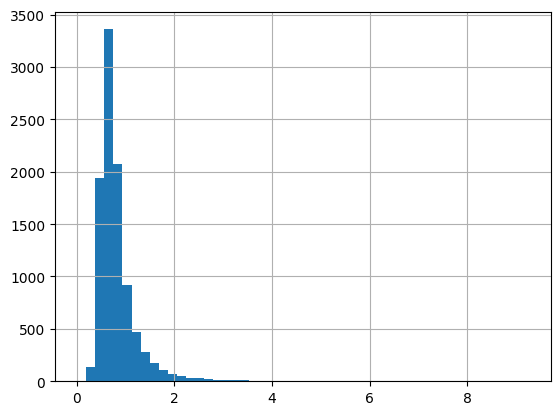

In [9]:
# Visualize the distribution of reaction times with a histogram
%matplotlib inline
data_for_model['rt'].hist(bins=50)
plt.show()

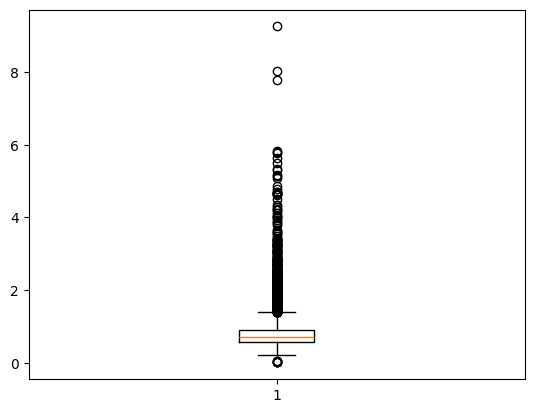

In [10]:
# Use a boxplot to visually confirm the presence of outliers in reaction times
plt.boxplot(data_for_model['rt'])
plt.show()

In [11]:
# Filter out extreme reaction times (rt >= 5 seconds) to improve model fitting
rt_threshold = 5.0
data_for_model_filtered = data_for_model[data_for_model['rt'] < rt_threshold]
print("Summary statistics of filtered reaction times:", data_for_model_filtered['rt'].describe())

Summary statistics of filtered reaction times: count    9737.000000
mean        0.821185
std         0.423111
min         0.010953
25%         0.584603
50%         0.714277
75%         0.908068
max         4.860230
Name: rt, dtype: float64


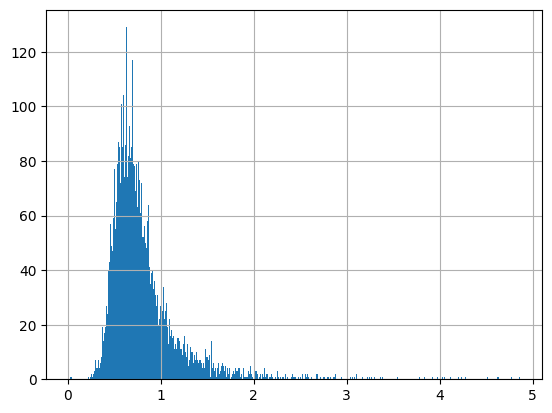

In [12]:
# Visualize the filtered reaction time distribution with a detailed histogram
%matplotlib inline
data_for_model_filtered['rt'].hist(bins=1000)
plt.show()

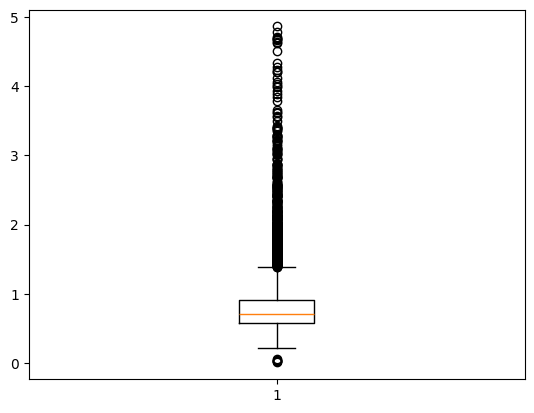

In [13]:
# Use a boxplot to check for remaining outliers in the filtered data
plt.boxplot(data_for_model_filtered['rt'])
plt.show()

<a id="section4"></a>
# 4. Define Model Components

In [15]:
# Define drift function for Model 1, dependent on HSF_emo conditions
def drift_function(HSF_emo_1, HSF_emo_2, t, x, leak, drift_emo1, drift_emo2):
    base_drift = (drift_emo1 * HSF_emo_1 + drift_emo2 * HSF_emo_2)  # Compute base drift based on HSF_emo conditions
    drift = base_drift - leak * x  # Apply leaky integrator to adjust drift based on accumulated evidence
    if np.any(np.isnan(drift)) or np.any(np.isinf(drift)):  # Check for numerical errors (NaN or infinite values)
        print(f"Drift function error: {drift}")
    return drift * np.ones_like(x)  # Ensure output shape matches input x for compatibility with pyDDM

In [16]:
# Define the bound function: The decision boundary decays over time to simulate urgency effects
def bound_function(threshold, invtau, t):
    """
    Parameters:
        threshold: Initial decision threshold
        invtau: Inverse of the decay rate for the threshold
        t: Time variable
    Returns:
        Decision boundary value at time t
    """
    bound = threshold * np.exp(-t * invtau)  # Exponential decay of the boundary
    if np.any(np.isnan(bound)) or np.any(np.isinf(bound)):
        print(f"Bound function error: {bound}")
    return bound

<a id="section5"></a>
# 5. Build and Configure Model

In [18]:
# Build and configure Model 1 with HSF_emo-dependent drift and exponential decay bound
model_1 = pyddm.gddm(
    drift=drift_function,  # Use the custom HSF_emo-dependent drift function
    noise=1.0,             # Fixed noise level for the diffusion process
    bound=bound_function,  # Use the custom exponential decay bound function
    nondecision="nt",      # Non-decision time parameter
    starting_position="x0",# Starting position parameter for evidence accumulation
    parameters={
        "drift_emo1": (0, 2),           # Range for drift rate under HSF_emo_1 condition
        "drift_emo2": (-2, 0),          # Range for drift rate under HSF_emo_2 condition
        "threshold": (0.3, 3),          # Range for initial decision threshold
        "x0": (-0.3, 0.3),              # Range for starting position of evidence
        "nt": (0.1, 1),                 # Range for non-decision time
        "leak": (0.001, 0.05),          # Range for leak parameter in the integrator
        "invtau": (0.1, 2)              # Range for decay rate in the bound function
    },
    conditions=["HSF_emo_1", "HSF_emo_2"],  # Specify HSF_emo dummy variables as conditions for drift
    T_dur=5.0  # Simulation duration in seconds
)

<a id="section6"></a>
# 6. Prepare Data Sample

In [20]:
# Convert the filtered DataFrame into a pyDDM Sample object for model fitting
data_sample_filtered = Sample.from_pandas_dataframe(data_for_model_filtered, rt_column_name='rt', choice_column_name='response')

<a id="section7"></a>
# 7. Model Fitting

In [22]:
# Attempt to fit Model 1 to the filtered data sample using BIC loss
try:
    model_1.fit(data_sample_filtered, lossfunction=pyddm.LossBIC, verbose=True)
except Exception as e:
    print(f"Error during Model 1 fitting: {e}")  # Report any fitting errors for debugging
    print(f"Current Model 1 parameters: {model_1.parameters}")  # Display parameters if fitting fails

Info: Model(name='', drift=DriftEasy(leak=Fitted(0.023071004547750795, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.878381593384018, minval=0, maxval=2), drift_emo2=Fitted(-0.7605947814895431, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.0993618820116422, minval=0.3, maxval=3), invtau=Fitted(0.9908835757556771, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.1741675859127361, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.5917027432225741, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=56949.96843718486
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.004549130377383307, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.5416912256206674, minval=0, maxval=2), drift_emo2=Fitted(-1.5949972086800706, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(2.9227927699615996, minval=0.3, maxval=3), invt

differential_evolution step 1: f(x)= 15397.269934965942


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.02102249166005416, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.1134698931825018, minval=0, maxval=2), drift_emo2=Fitted(-1.0743210271690447, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.3871337240036736, minval=0.3, maxval=3), invtau=Fitted(1.879579296250942, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.06425577095209518, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.36923137370745196, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=22267.695963898823
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.022033327428332302, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.8110848546151007, minval=0, maxval=2), drift_emo2=Fitted(-1.2558940869777075, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.6021794364123207, minval=0.3, maxval=3), in

differential_evolution step 2: f(x)= 15397.269934965942


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.020485608902133405, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.1011478168542965, minval=0, maxval=2), drift_emo2=Fitted(-0.06816743464142827, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.6021794364123207, minval=0.3, maxval=3), invtau=Fitted(1.3307763560526957, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.17727310841680002, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.8214264318589746, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=89843.50946252873
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.043681265956364665, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.1815856433890557, minval=0, maxval=2), drift_emo2=Fitted(-1.746001980659476, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.79701506882882, minval=0.3, maxval=3), invt

differential_evolution step 3: f(x)= 15397.269934965942


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.04553944283801786, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.519036407825256, minval=0, maxval=2), drift_emo2=Fitted(-0.1879024484973102, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8423978543573444, minval=0.3, maxval=3), invtau=Fitted(1.2775417149313493, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.015248207524372325, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.25899806711102313, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=23800.005987565368
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03549998706078777, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.9261124898095872, minval=0, maxval=2), drift_emo2=Fitted(-0.7671715630037439, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.773294031655946, minval=0.3, maxval=3), in

differential_evolution step 4: f(x)= 15375.177080618918


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03543772657912448, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.2125046166673434, minval=0, maxval=2), drift_emo2=Fitted(-1.436444419295269, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9562309100574827, minval=0.3, maxval=3), invtau=Fitted(0.5489195280587839, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.2501846770403221, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2604550986253972, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17857.02020729325
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.024306228366429435, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.2254456347503802, minval=0, maxval=2), drift_emo2=Fitted(-0.8649836676949598, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.6527043706535496, minval=0.3, maxval=3), invta

differential_evolution step 5: f(x)= 15375.177080618918


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.015321625319329476, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.12178365497282018, minval=0, maxval=2), drift_emo2=Fitted(-0.07286293749896688, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.5633531114353794, minval=0.3, maxval=3), invtau=Fitted(0.26305055501075625, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.004487671469158294, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.11084963101794593, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=26784.25569759572
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03858067150176482, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.8380637401822701, minval=0, maxval=2), drift_emo2=Fitted(-0.1567855521039183, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(2.032609932853607, minval=0.3, maxval=3),

differential_evolution step 6: f(x)= 15262.927013331628


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03143529559118082, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.519036407825256, minval=0, maxval=2), drift_emo2=Fitted(-0.255728086321938, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8423978543573444, minval=0.3, maxval=3), invtau=Fitted(0.9833637326704666, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.13302153022042099, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.43498702794843047, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=21912.149354668545
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.04007446706730494, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.6445752752803467, minval=0, maxval=2), drift_emo2=Fitted(-1.3088663725995024, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8620172433549798, minval=0.3, maxval=3), inv

differential_evolution step 7: f(x)= 14911.77387416486


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.01622816875597689, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.7309420369984306, minval=0, maxval=2), drift_emo2=Fitted(-0.7034647357043486, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8891358691790521, minval=0.3, maxval=3), invtau=Fitted(0.4816558100724747, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.004487671469158294, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.10229810293188701, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=21778.650816736405
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.021887499451153335, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.15516960520297796, minval=0, maxval=2), drift_emo2=Fitted(-1.746001980659476, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7659112658290398, minval=0.3, maxval=3), 

differential_evolution step 8: f(x)= 14911.77387416486


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.021887499451153335, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.309271650041529, minval=0, maxval=2), drift_emo2=Fitted(-0.1844417943436003, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7659112658290398, minval=0.3, maxval=3), invtau=Fitted(0.36315592747567815, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.03497467416129992, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3092486494083989, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15112.622709130324
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.016587588368384247, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.28577219419839583, minval=0, maxval=2), drift_emo2=Fitted(-0.347587274780524, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.6760790375898966, minval=0.3, maxval=3), 

differential_evolution step 9: f(x)= 14613.470448338652


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03308199928519197, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.9574621625673825, minval=0, maxval=2), drift_emo2=Fitted(-0.56448472956774, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.6128045969069944, minval=0.3, maxval=3), invtau=Fitted(0.13037113041649606, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.0031945720714044224, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.4394583049361586, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=18474.802234067673
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03756486109409029, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.8512884289231959, minval=0, maxval=2), drift_emo2=Fitted(-0.07458856003430725, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.3550173663797533, minval=0.3, maxval=3), 

differential_evolution step 10: f(x)= 14580.827229535218


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.04586373798497264, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.9939411342474143, minval=0, maxval=2), drift_emo2=Fitted(-0.35749532492606706, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8764312501496575, minval=0.3, maxval=3), invtau=Fitted(0.4921059691373032, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.12914770549134608, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2749932114768929, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15299.36168490392
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.04854986640967985, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.45995797027994834, minval=0, maxval=2), drift_emo2=Fitted(-0.5002543991164141, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7659112658290398, minval=0.3, maxval=3), in

differential_evolution step 11: f(x)= 14492.349984948185


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.021887499451153335, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.1887922811605243, minval=0, maxval=2), drift_emo2=Fitted(-0.23955821214377404, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.962675080293859, minval=0.3, maxval=3), invtau=Fitted(0.20552404148497394, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.03497467416129992, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3092486494083989, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15711.171664535714
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.037294782594411616, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.7326074416507498, minval=0, maxval=2), drift_emo2=Fitted(-0.347587274780524, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.3550173663797533, minval=0.3, maxval=3), 

differential_evolution step 12: f(x)= 14492.349984948185


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03633781731767147, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.1913517330191783, minval=0, maxval=2), drift_emo2=Fitted(-0.6200870853367169, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7481946614582131, minval=0.3, maxval=3), invtau=Fitted(0.6360363626451593, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.1283306794173236, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3092486494083989, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17568.62135972163
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.04221270100484863, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.7032722329309617, minval=0, maxval=2), drift_emo2=Fitted(-0.5379372635815574, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.894475968147911, minval=0.3, maxval=3), invtau

differential_evolution step 13: f(x)= 14482.156782972434


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.01978367735031538, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.2707899877839344, minval=0, maxval=2), drift_emo2=Fitted(-0.1844417943436003, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.107903482513098, minval=0.3, maxval=3), invtau=Fitted(0.9612218399665322, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.10418216820934338, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.29941202773335857, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15411.845657725518
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03617438560902959, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.7032722329309617, minval=0, maxval=2), drift_emo2=Fitted(-0.824478879204096, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9530223812390025, minval=0.3, maxval=3), inv

differential_evolution step 14: f(x)= 14482.156782972434


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.021887499451153335, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.1423997492622786, minval=0, maxval=2), drift_emo2=Fitted(-0.3544632694871823, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.039407666072203, minval=0.3, maxval=3), invtau=Fitted(0.8509784082726646, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.029986442855588567, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26872344172784945, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14874.48600427604
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03617438560902959, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.7032722329309617, minval=0, maxval=2), drift_emo2=Fitted(-0.6168380190739369, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8458303595022885, minval=0.3, maxval=3), i

differential_evolution step 15: f(x)= 14444.432313611105


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.021887499451153335, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.8805476919510196, minval=0, maxval=2), drift_emo2=Fitted(-0.33939139581483446, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.039407666072203, minval=0.3, maxval=3), invtau=Fitted(0.8509784082726646, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.029986442855588567, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.23705985633139043, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15356.090457462775
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03617438560902959, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.6053642391734047, minval=0, maxval=2), drift_emo2=Fitted(-0.4367279502252437, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9530223812390025, minval=0.3, maxval=3),

differential_evolution step 16: f(x)= 14444.432313611105


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.0261454137147299, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.1423997492622786, minval=0, maxval=2), drift_emo2=Fitted(-0.17733096424379924, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8085586375289859, minval=0.3, maxval=3), invtau=Fitted(0.25250184856072366, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.04470462966916374, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26872344172784945, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15187.525274937732
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.023170388428642087, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.43631423694234, minval=0, maxval=2), drift_emo2=Fitted(-0.49594960063464955, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.720317681040393, minval=0.3, maxval=3), i

differential_evolution step 17: f(x)= 14444.432313611105


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.039768880490952944, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.2702465829413707, minval=0, maxval=2), drift_emo2=Fitted(-0.36062648128683783, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.5885480361065729, minval=0.3, maxval=3), invtau=Fitted(0.5126855398782851, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.017076291450487568, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26872344172784945, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=26706.050497736433
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.03617438560902959, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.7032722329309617, minval=0, maxval=2), drift_emo2=Fitted(-0.27919150701496775, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8662283682603014, minval=0.3, maxval=3)

differential_evolution step 18: f(x)= 14367.402572304472


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.021887499451153335, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.8081066487422289, minval=0, maxval=2), drift_emo2=Fitted(-0.41680854556178026, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.6428373940653753, minval=0.3, maxval=3), invtau=Fitted(0.8509784082726646, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.10746028005986905, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.37860961461846454, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=20200.598103917087
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.023920983471901105, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.0959271981204222, minval=0, maxval=2), drift_emo2=Fitted(-0.6789909982510915, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9530223812390025, minval=0.3, maxval=3),

differential_evolution step 19: f(x)= 14362.844106598197


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.02488275642221455, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.2716534963491537, minval=0, maxval=2), drift_emo2=Fitted(-0.4061132383186743, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.039407666072203, minval=0.3, maxval=3), invtau=Fitted(0.39427860158113637, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.029986442855588567, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.29174041901564224, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15331.96000427669
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.005143902396117457, minval=0.001, maxval=0.05), drift_emo1=Fitted(0.9377270140446368, minval=0, maxval=2), drift_emo2=Fitted(-0.42566805165750643, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8989588568007338, minval=0.3, maxval=3),

differential_evolution step 20: f(x)= 14333.298332835242


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.006290221955990893, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.2991787903725254, minval=0, maxval=2), drift_emo2=Fitted(-0.34688756448026337, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.039407666072203, minval=0.3, maxval=3), invtau=Fitted(0.8509784082726646, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(-0.04155987416622425, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.31365575873498885, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15095.779213128517
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.04230928190967735, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.0929618630251154, minval=0, maxval=2), drift_emo2=Fitted(-0.42566805165750643, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9087874004491816, minval=0.3, maxval=3),

differential_evolution step 21: f(x)= 14333.298332835242
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftEasy(leak=Fitted(0.0028734259282429155, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.102962965521905, minval=0, maxval=2), drift_emo2=Fitted(-0.40569695031620645, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8621149709968725, minval=0.3, maxval=3), invtau=Fitted(0.39795393993260075, minval=0.1, maxval=2)), IC=ICPointRatio(x0=Fitted(0.019497082056747495, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3140894401343366, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14333.298335062042
Info: Model(name='', drift=DriftEasy(leak=Fitted(0.0028734259282429155, minval=0.001, maxval=0.05), drift_emo1=Fitted(1.102962965521905, minval=0, maxval=2), drift_emo2=Fitted(-0.40569695031620645, minval=-2, maxval=0)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8621149609968725, minval=0.3, maxval=3

In [23]:
# Display the fitted model details
model_1.show()

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - leak: 0.002866
    - drift_emo1: 1.098813
    - drift_emo2: -0.404170
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundEasy:
    easy_bound
    Fitted parameters:
    - threshold: 0.860000
    - invtau: 0.396834
IC component ICPointRatio:
    An arbitrary starting point expressed as a proportion of the distance between the bounds.
    Fitted parameters:
    - x0: 0.019497
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.314089
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.020000
Fit information:
    Loss function: BIC
    Loss function value: 14331.3567002901

<a id="section8"></a>
# 8. Visualization and Analysis

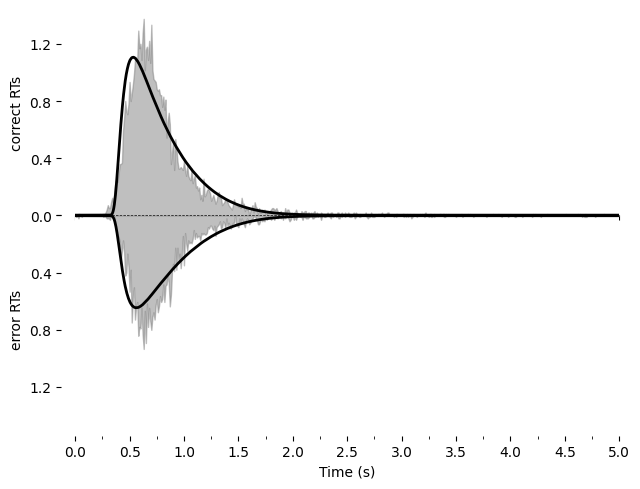

In [25]:
# Visualize model fit diagnostics to evaluate performance
%matplotlib inline
pyddm.plot.plot_fit_diagnostics(model=model_1, sample=data_sample_filtered)
plt.show()